# *How Autoencoders work - Understanding the math and implemantation*

# 1. Introduction

> 오토인코더란 무엇인가?
- 오토인코더는 입력을 그대로 똑같이 출력을 만드는 특별한 유형의 신경망이다. 오토인코더는 비지도 학습으로 입력데이터에 대한 low-level의 성질을 학습하기 위해 사용한다. 이러한 low-level성질은 실제 데이터로 '재구성'하는데 도움을준다.
- 오토인코더는 네트워크가 입력을 예측하도록 요구하는 회귀작업이라고 볼 수 있다. 이 네트워크는 중간에 병목 현상이 있고, 이런 병목은 후에 디코더의 원본데이터로 다시 변환하기 위해 필요한 입력 데이터를 효과적인 표현으로 압축해주는 효과를 가진다.

> 오토인코더의 3가지 구성요소
- Encoding Architecture : 인코더 구조는 일련의 레이어로 구성되고, 이를 이용해 노드를 감소시킨다. 그리고 잠재 공간 표현의 크기를 매우 줄여준다.
- Latent View Architecture : 잠복 공간은 줄어든 입력 정보가 보존되는 가장 낮은 레벨 공간을 나타낸다.
- Decoding Architecture : 인코딩 구조와 대칭되는 거울상이지만, 모든 레이어의 노드 수가 증가하고 궁극적으로 거의 유사한 입력을 출력한다.

> 매우 섬세하게 조정된 오토인코딩 모델은 첫 번째 레이어에서 전달된 동일한 입력을 재구성 할 수 있어야한다.

> 오토인코더는 이미지 데이터에 많이 사용되고, 다음과 같은 사례에서 사용할 수 있다.
- 차원 축소
- 이미지 압축
- 이미지 노이즈 제거
- 이미지 생성
- 특성 추출

# 2. Implementation 

> 2.1 UseCase 1 : Image Reconstruction

In [2]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
#케라스의 dense, conv, lstm를 활요하기 위한 모델 import
from sklearn.model_selection import train_test_split
#데이터를 train, val데이터로 나눠주는 모듈
from keras.callbacks import EarlyStopping
#과적합을 막기 위한 모듈, train의 score는 높아지고 val의 score는 낮아질 때 stopping
from keras.utils import to_categorical
#categorical한 데이터로 만들어주는 모듈
from keras.models import Model
from imgaug import augmenters
#이미지에 노이즈를 추가하기 위한 모듈
from random import randint
import numpy as np
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values
#train파일을 불러온 후 예측값과 타겟값을 분리하여 저장

train_x = train_x/255

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)
#train데이터와 val데이터로 나눠저 저장

train_x = train_x.reshape(-1,784)
val_x = val_x.reshape(-1,784)
#크기를 784로 조정 -> 크기가 28x28이기 때문

In [5]:
input_layer = Input(shape=(784,))
#input layer

encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)
#encoding architecture

latent_view = Dense(10, activation='sigmoid')(encode_layer3)
#latent_view

decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)
#decoding architecture

output_layer = Dense(784)(decode_layer3)
#output_layer

model = Model(input_layer,output_layer)

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              5010

In [7]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
#EarlyStopping은 NN가 과적합이 일어나기 전에 종료 즉, training loss감소, val loss가 증가하면 early stop
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x,val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 50us/step - loss: 0.0978 - val_loss: 0.0721
Epoch 2/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0648 - val_loss: 0.0557
Epoch 3/20
48000/48000 [==============================] - 1s 25us/step - loss: 0.0483 - val_loss: 0.0422
Epoch 4/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0396 - val_loss: 0.0385
Epoch 5/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0366 - val_loss: 0.0356
Epoch 6/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0340 - val_loss: 0.0320
Epoch 7/20
48000/48000 [==============================] - 1s 25us/step - loss: 0.0309 - val_loss: 0.0297
Epoch 8/20
48000/48000 [==============================] - 1s 25us/step - loss: 0.0284 - val_loss: 0.0292
Epoch 9/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.0276 - val_loss: 0.0258
Epoch

In [8]:
preds = model.predict(val_x)

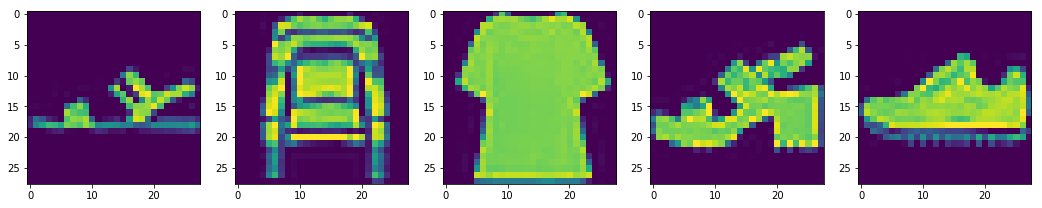

In [9]:
from PIL import Image
f, ax = plt.subplots(1,5, figsize=(18,4))
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28,28))
plt.show()
#Inputs : Actual Images

In [10]:
val_x.shape

(12000, 784)

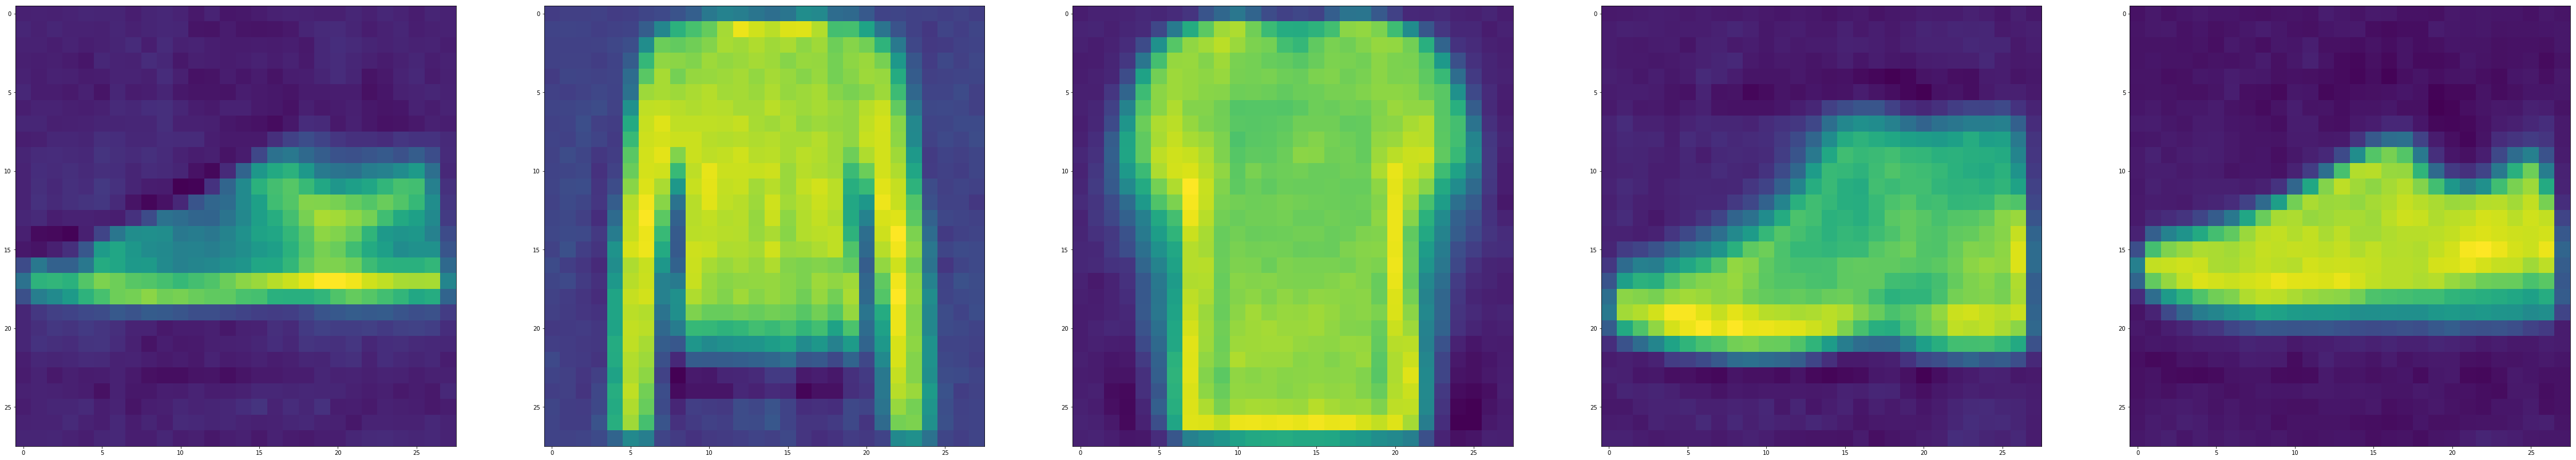

In [11]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28,28))
plt.show()
#Predicted : Autoencoder Output

#######################여기까지함

- 20epochs만으로 입력 이미지를 다시 잘 구성하는 것을 확인 할 수 있다.

> 2.2 UseCase 2 : Image Denoising

In [12]:
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

train_x = train_x/255
val_x = val_x/255

In [13]:
train_x = train_x.reshape(-1,28,28,1)
val_x = val_x.reshape(-1,28,28,1)
#convolution network에 넣기 위해 28x28로 reshape

In [14]:
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255
#의도적으로 이미지에 노이즈를 추가

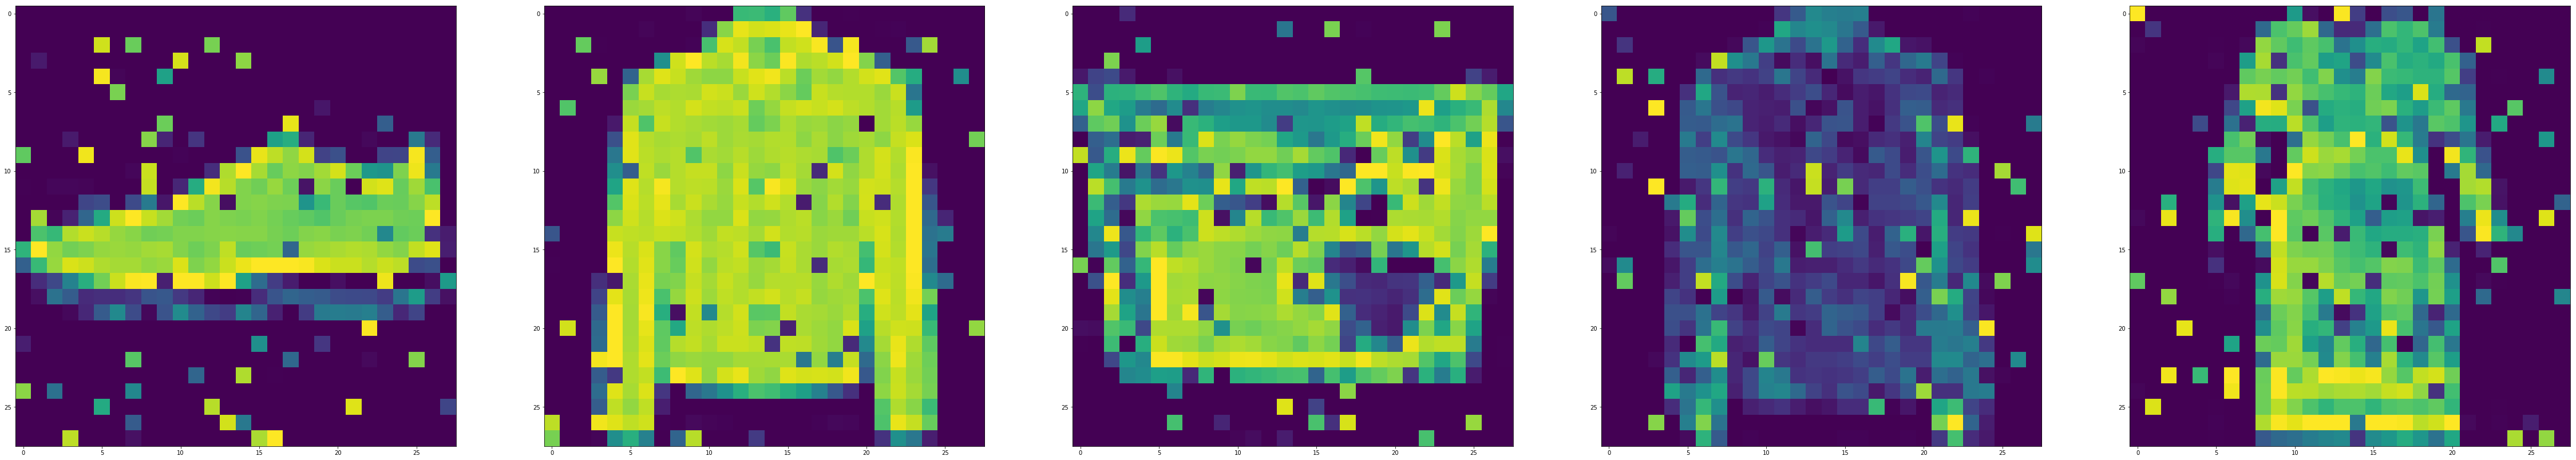

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28,28))
plt.show()

In [16]:
input_layer = Input(shape=(28,28,1))
#Input layer

encoded_layer1 = Conv2D(64,(3,3), activation='relu', padding='same')(input_layer)
#TensorShape([None, 28, 28, 64])
encoded_layer1 = MaxPool2D((2,2),padding='same')(encoded_layer1)
#TensorShape([None, 14, 14, 64])
encoded_layer2 = Conv2D(32,(3,3), activation='relu', padding='same')(encoded_layer1)
#TensorShape([None, 14, 14, 32])
encoded_layer2 = MaxPool2D((2,2), padding='same')(encoded_layer2)
#TensorShape([None, 7, 7, 32])
encoded_layer3 = Conv2D(16, (3,3), activation='relu', padding='same')(encoded_layer2)
#TensorShape([None, 7, 7, 16])

latent_view = MaxPool2D((2,2), padding='same')(encoded_layer3)
#TensorShape([None, 4, 4, 16])
#encoding architecture

decoded_layer1 = Conv2D(16, (3,3), activation='relu', padding='same')(latent_view)
#TensorShape([None, 4, 4, 16])
decoded_layer1 = UpSampling2D((2,2))(decoded_layer1)
#TensorShape([None, 8, 8, 16])
decoded_layer2 = Conv2D(32, (3,3), activation='relu', padding='same')(decoded_layer1)
#TensorShape([None, 8, 8, 32])
decoded_layer2 = UpSampling2D((2,2))(decoded_layer2)
#TensorShape([None, 16, 16, 32])
decoded_layer3 = Conv2D(64, (3,3), activation='relu')(decoded_layer2)
#TensorShape([None, 14, 14, 64])
decoded_layer3 = UpSampling2D((2,2))(decoded_layer3)
#TensorShape([None, 28, 28, 64])
output_layer = Conv2D(1,(3,3), padding='same')(decoded_layer3)
#TensorShape([None, 28, 28, 1])

model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [17]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0   

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n,train_x, epochs=10,batch_size=2048,validation_data=(val_x_n,val_x),callbacks=[early_stopping])
#과적합을 막기 위헤 EarlyStopping사용

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 108us/step - loss: 0.1005 - val_loss: 0.0625
Epoch 2/10
48000/48000 [==============================] - 2s 48us/step - loss: 0.0491 - val_loss: 0.0402
Epoch 3/10
48000/48000 [==============================] - 2s 51us/step - loss: 0.0369 - val_loss: 0.0336
Epoch 4/10
48000/48000 [==============================] - 2s 52us/step - loss: 0.0314 - val_loss: 0.0293
Epoch 5/10
48000/48000 [==============================] - 2s 50us/step - loss: 0.0277 - val_loss: 0.0263
Epoch 6/10
48000/48000 [==============================] - 2s 50us/step - loss: 0.0253 - val_loss: 0.0244
Epoch 7/10
48000/48000 [==============================] - 2s 51us/step - loss: 0.0238 - val_loss: 0.0234
Epoch 8/10
48000/48000 [==============================] - 2s 50us/step - loss: 0.0228 - val_loss: 0.0223
Epoch 9/10
48000/48000 [==============================] - 2s 50us/step - loss: 0.0219 - val_loss: 0.0217
Epoc

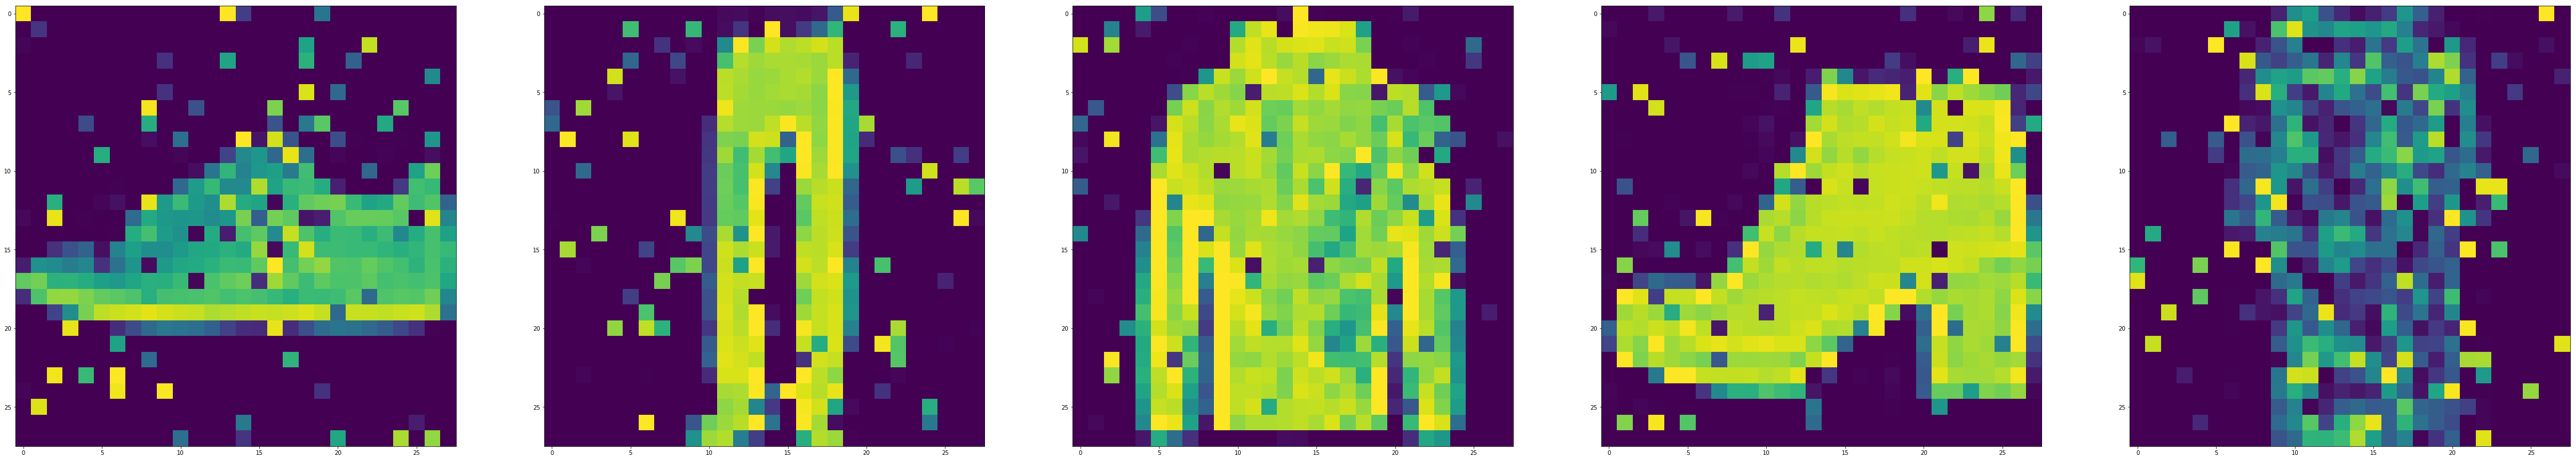

In [22]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10):
    ax[i-5].imshow(val_x_n[i].reshape(28,28))
plt.show()
#노이즈가 적용된 검증 데이터

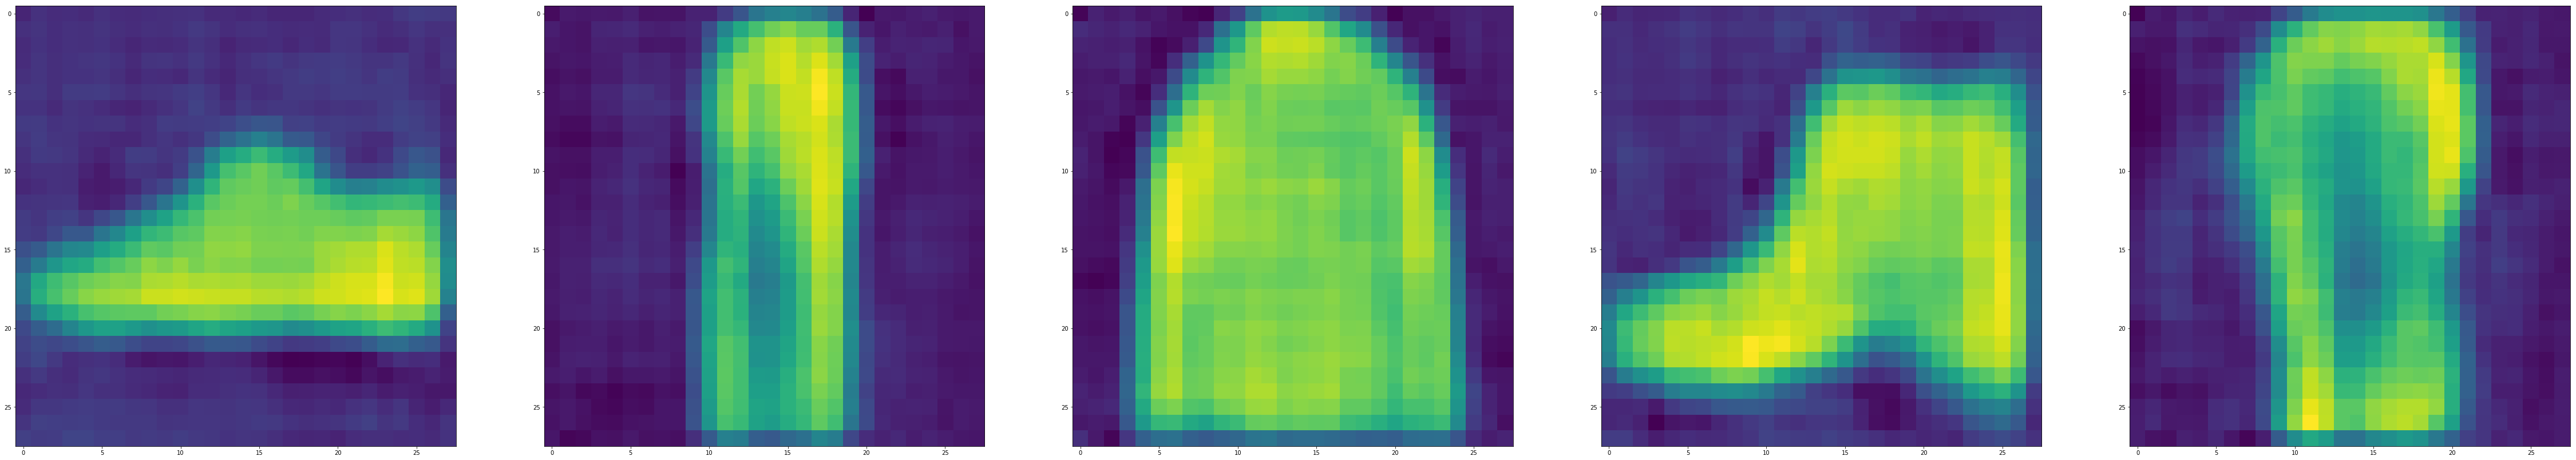

In [24]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28,28))
plt.show()
#노이즈를 없앤 오토인코딩 후 검증데이터

> 2.3 UseCase 3 : Sequence to Sequence Prediction using AutoEncoders

> Autoencoder Architecture
- Long Short-Term Memory, LSTM은 내부 루프로 구성된 반복적 신경망이다.
- 다른 RNN과 다르게 backpropagation throught time, BPTT를 활용하여 효과적인 훈련을 하고, 사라지는 그래디언트 문제를 방지한다.
- LSTM layer에서 메모리 유닛을 정의할 수 있고, layer에 속하지 않은 각 유닛은 셀의 상태를 나타내는 c와 숨겨진 상태이자 출력인 h 등이 있다.
- keras를 사용하면, LSTM 레이어의 출력 상태와 LSTM 레이어의 현재 상태에 모두 접근 할 수 있다.

> 고정 길이의 무작위 시퀀스를 포함하는 시퀀스 데이터 세트를 생성
- X1은 난수를 포함하는 입력 시퀀스
- X2는 시원스의 다른 요소를 재생산하기 위해 시드로 사용되는 패딩 된 시퀀스를 의미
- y는 대상 시퀀스 또는 실제 시퀀스

In [26]:
def dataset_preparation(n_in, n_out, n_unique, n_samples):
    X1, X2, y = [], [], []
    for _ in range(n_samples): 
        inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]
        #난수를 생성
        
        target = inp_seq[:n_out]
        #target값 생성
    
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]  
        #다른 요소로 재생산하기 위해 사용되는 패딩 된 시퀀스
       
        X1.append(to_categorical([inp_seq], num_classes=n_unique))
        X2.append(to_categorical([seed_seq], num_classes=n_unique))
        y.append(to_categorical([target_seq], num_classes=n_unique))
         # convert the elements to categorical using keras api
    
    X1 = np.squeeze(np.array(X1), axis=1) 
    X2 = np.squeeze(np.array(X2), axis=1) 
    y  = np.squeeze(np.array(y), axis=1) 
    #필요없는 차원 삭제
    return X1, X2, y

samples = 100000
features = 51
inp_size = 6
out_size = 3

inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)
print("Shapes: ", inputs.shape, seeds.shape, outputs.shape)
print ("Here is first categorically encoded input sequence looks like: ", )
inputs[0][0]

Shapes:  (100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
Here is first categorically encoded input sequence looks like: 


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

> 학습과 생성을 하는 오토인코더 구조는 2가지 요소로 이루어진다.
- 시퀀스를 입력으로 받아들이고 LSTM의 현재 상태를 출력으로 반환하는 인코더 아키텍처
- 시퀀스 및 인코더 LSTM 상태를 입력으로 받아 디코딩 된 출력 시퀀스를 반환하는 디코더 아키텍처
- LSTM의 숨겨진 상태와 메모리 상태를 저장하고 (숨겨진 그리고 상태들을) 접근하므로, 보이지 않는 데이터에 대한 예측을 생성하는 동안 LSTM을 사용할 수 있다.

In [27]:
def define_models(n_input, n_output): 
    encoder_inputs = Input(shape=(None, n_input))
    #<tf.Tensor 'input_27:0' shape=(None, None, 51) dtype=float32>
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    #encoder_outputs = <tf.Tensor 'lstm_3/strided_slice_18:0' shape=(None, 128) dtype=float32>
    encoder_states = [state_h, state_c]
    encoder_model = Model(encoder_inputs, encoder_states)
    #encoder architecture 생성
    ## input : sequence 
    ## output : encoder states
    
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    #decoder_outputs = <tf.Tensor 'lstm_8/transpose_1:0' shape=(None, None, 128) dtype=float32>
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    #decoder_outputs = <tf.Tensor 'dense_9/truediv:0' shape=(None, None, 51) dtype=float32>
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #encoder-decoder architecture 생성
    ## input : a seed sequence 
    ## output : decoder states, decoded output 
    
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    #decoder_outputs = <tf.Tensor 'lstm_12_1/transpose_1:0' shape=(None, None, 128) dtype=float32>
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    #decoder 모델 생성
    ## input : current states + encoded sequence
    ## output : decoded sequence
    
    return model, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = define_models(features, features)

In [28]:
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 51)          0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 128), (None, 128) 92160     
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


In [29]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 input_5[0][0]              

In [30]:
autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 92160       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 lstm_1[0][1]               

In [31]:
autoencoder.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
#오토인코더 모델을 아담 옵티마이저와 Categorical Cross Entropy(CCE)손실함수를 사용하여 훈련
autoencoder.fit([inputs,seeds], outputs, epochs=1)
#오토인코더 입력 두개로 넣은 이유

Epoch 1/1
100000/100000 [==============================] - 43s 428us/step - loss: 0.6576 - acc: 0.7921


In [ ]:
def reverse_onehot(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

def predict_sequence(encoder, decoder, sequence):
    output = []
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1, 1, features)

    current_state = encoder.predict(sequence)
    for t in range(out_size):
        pred, h, c = decoder.predict([target_seq] + current_state)
        output.append(pred[0, 0, :])
        current_state = [h, c]
        target_seq = pred
    return np.array(output)

In [ ]:
for k in range(5):
    X1, X2, y = dataset_preparation(inp_size, out_size, features, 1)
    target = predict_sequence(encoder_model, decoder_model, X1)
    print('\nInput Sequence=%s SeedSequence=%s, PredictedSequence=%s' 
          % (reverse_onehot(X1[0]), reverse_onehot(y[0]), reverse_onehot(target)))

> 출처 : https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

> 출처 : https://www.kaggle.com/subinium/how-autoencoders-work-korean-ver